# Lab 03: Numerical Derivatives

## Objectives

The main focus of this lab is to study numerical derivatives using center differencing and Richardson extrapolation.
We will also learn about the dangers of calculating numerical derivatives of noisy data.
Do *not* use any loops in this lab!
(Besides the ones that appear in the `richardson_center` function, of course.)

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

We will be using random numbers in this lab so create a random number generator in this initialization cell using
```
rng = np.random.default_rng()
```
We will see this more times throughout the semester but not fully talk about it until the very end!

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sf
rng = np.random.default_rng()

## Derivatives of Data

One reason why calculating numerical derivatives is not too common is that calculating numerical derivatives of data is something that must be done with great care.
The main reason for this is that data is noisy.
Here you will explore that.
We again consider a simple function,
$$ f(\theta) = \cos\theta, $$
for which the derivative is simply
$$ f'(\theta) = -\sin\theta. $$

Suppose we take measurements of this function at 20 equally spaced points in the interval $0\le\theta\le 2\pi$.
An actual measurement has uncertainties which are often Gaussian distributed.
We will model our errors by *adding* Gaussian random noise to the true values from a distribution with variance (width) of 0.2.
Recall from Lab 0 that we can choose Gaussian random variables using the `normal` function as `rng.normal(size=N)` to generate `N` values.
This will return random values with variance 1, one way to change this to 0.2 is to just multiply the returned values by 0.2 before adding it to the true function values.
(See the documentation of `rng.normal` for an alternative approach.)

Once you have generated the "data" we want to take its derivative using center differencing.
Since center differencing uses values to the left and right of where we are calculating the derivative we are unable to calculate it at the first and last points.
(We could correct this by using forward and backward differencing at these points or the higher order methods discussed in the lecture or by using `np.gradient` which will do that for us, but will not do so here.
The point is to learn something by doing this ourselves.)
How do we calculate all the required derivatives without writing a loop?
Once again we will use array slicing!
(At this point you should start to appreciate that array slicing is very powerful.
We will see it in more detail soon.)
Notice that for $N$ points we want to calculate the derivatives
\begin{align}
 f'_1 &= \frac{f_2-f_0}{2h}, \\
 f'_2 &= \frac{f_3-f_1}{2h}, \\
 \vdots &= \vdots \\
 f'_{n-2} &= \frac{f_{n-1}-f_{n-3}}{2h}.
 \end{align}
To calculate all the derivatives we are taking the values $f_2$, $f_3$, $\ldots$, $f_{n-1}$ and subtracting off $f_0$, $f_1$, $\ldots$, $f_{n-3}$.
Given an array, `a`, we can access the first set of values as `a[2:]` and the second set as `a[:-2]`.
(Read that again carefully!)
Using this slicing in the calculation we will get an array back with $n-2$ entries corresponding to derivatives at the points $\theta_1$, $\theta_2$, $\ldots$, $\theta_{n-2}$.
Given an array of values `theta` as specified above, how can we slice it to only get these values?
(This will be useful for the plot below.)

Put all this together and produce a single plot.
1. Create your noisy data.
2. Plot points for the noisy data and a (smooth) curve showing the true function from the which the data was generated.
3. Calculate the numerical derivative of your noisy data using center differencing.
4. Plot points for the derivative of the noisy data and a (smooth) curve showing the true derivative.

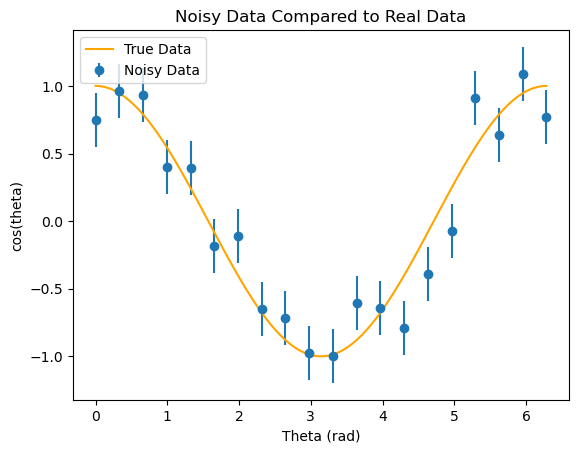

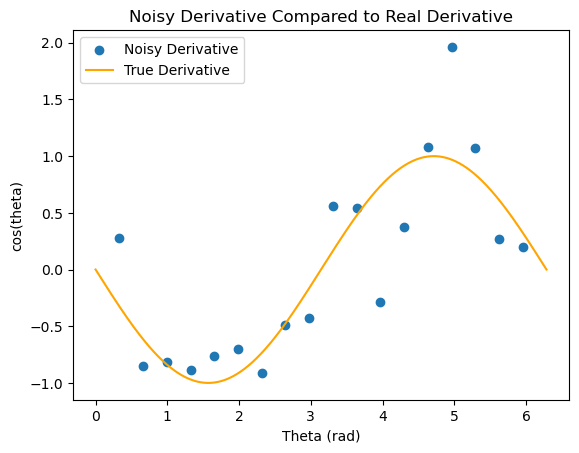

In [34]:
thetas = np.linspace(0, 2 * np.pi, 20)
data = np.cos(thetas) + rng.normal(size=20) * 0.2
thetas_fine = np.linspace(0, 2 * np.pi, 1_000)

plt.errorbar(thetas, data, np.full_like(data, 0.2), fmt='o', label="Noisy Data")
plt.plot(thetas_fine, np.cos(thetas_fine), label="True Data", c="orange")
plt.title("Noisy Data Compared to Real Data")
plt.xlabel("Theta (rad)")
plt.ylabel("cos(theta)")
plt.legend()

def f_deriv(thetas):
    hs = (thetas[2:] - thetas[:-2])/2
    return(data[2:] - data[:-2])/(2*hs)


plt.figure()
plt.scatter(thetas[1:-1], f_deriv(thetas), label="Noisy Derivative")
plt.plot(thetas_fine, -np.sin(thetas_fine), label="True Derivative", c="orange")
plt.title("Noisy Derivative Compared to Real Derivative")
plt.xlabel("Theta (rad)")
plt.ylabel("cos(theta)")
plt.legend()

Based on your results briefly describe the danger of taking derivative of noisy data.
When using random sampling it is good practice to run you code a few times to see how things change when different random data is generated so you can separate the general patterns from the specific details of each realization.

The danger of taking the derivative of noisy data is that one singular point doesn't tell you much about the tangent line. For example, if I wanted to linearly interpolate using the derivative, the derivative could have the wrong sign and the tangent line implied by the derivative might be going in the wrong direction. The derivative from the noisy data is very erratic, has a large difference from the true value, and isn't useful for telling us what the actual derivative is at a point without further processing to filter noise.

## Derivatives of Bessel Functions

The solution to many physical problems involve special functions.
One example is the set of Bessel functions.
If you have not encountered them yet, you will.
They typically show up in systems with cylindrical symmetry.
There are many types of Bessel functions but we will focus on the ordinary Bessel functions of order $\nu$ and of the first kind, $J_\nu(x)$, and the second kind, $Y_\nu(x)$ (sometimes also called the Neumann function and denoted $N_\nu(x)$).
Note that we are considering $\nu$ to be a real number.

Here we will consider taking the derivative with respect to the order, $\nu$, **not the derivative with respect to $x$**.
Admittedly this is rather a contrived example, but it is difficult to find an interesting and compelling example of numerical derivatives.

To begin, we will take the derivative evaluated at $\nu=0$.
Though this derivative seems strange, it can be done analytically to get the known result,
$$ \left. \frac{\mathrm{d}J_\nu(x)}{\mathrm{d}\nu} \right|_{\nu=0} = \frac\pi{2} Y_0(x). $$
We will compare this result to numerical calculations using forward and center differencing.
**Note:** We are calculating the *derivative with respect to the order*, $\nu$, **not** with respect to the argument $x$.
We do not normally think about taking derivatives like this, but we certainly can and will do so here.

### Special Functions in Python

The Bessel functions and many of the other important special functions are not part of the `numpy` module. The simplest way to access such functions for us will be with the module `scipy.special`.
For a list of the special functions (and how to use them) check the documentation!

Suppose we `import scipy.special as sf`.
For us the relevant functions are `sf.jv` or `sf.jn` for Bessel functions of the first kind and `sf.yv` or `sf.yn` for the second kind.
Here the `v` in the name represents what we have been calling $\nu$ and is used when the order is a real number.
Similarly, `n` in the name represents when $\nu=n$ is an integer.
Furthermore, for small (integer) values of $n$ there is often an explicit implementation of that function.
For example the special function $Y_0(x)$ can be called as `sf.y0(x)`, as `sf.yn(0,x)`, or as `sf.yv(0,x)`.
You should prefer the first over the second and the second over the third.
In other words, **when it makes sense to do so**, it is typically best to use the most specific form of the function that is available.
Again, check the documentation just like we do when going over examples!

### Simple Calculation

Calculate the derivative for $x=3.5$ of $J_\nu(x)$ at $\nu=0$.
Let $h=0.5$.
Evaluate this derivative using both forward and center differencing for step sizes of both $h$ and $h/2$.
Print the fractional error for all cases.
**Note:** Recall that we are taking the derivative with respect to $\nu$ **not** with respect to $x$.
Also recall the lesson we learned when talking about limited precision.
What is the "right" way to calculate the step size, $h$?
Does it matter here?
Why or why not?

In [35]:
x = 3.5
h = 0.5

def fwd_diff(f, x0, h):
    return (f(x0 + h) - f(x0)) / h

def ctr_diff(f, x0, h):
    return (f(x0 + h) - f(x0 - h)) / (2 * h)

numeric_fwd_h       = fwd_diff(lambda v: sf.jv(v, x), 0, h)
numeric_fwd_h_div_2 = fwd_diff(lambda v: sf.jv(v, x), 0, h / 2)
numeric_ctr_h       = ctr_diff(lambda v: sf.jv(v, x), 0, h)
numeric_ctr_h_div_2 = ctr_diff(lambda v: sf.jv(v, x), 0, h / 2)
analytic = np.pi / 2 * sf.y0(x)

print(f"""Results:
analytic deriv      = {analytic}
numeric_fwd_h       = {numeric_fwd_h      }, frac_err = {np.abs((numeric_fwd_h       - analytic) / analytic)}
numeric_fwd_h_div_2 = {numeric_fwd_h_div_2}, frac_err = {np.abs((numeric_fwd_h_div_2 - analytic) / analytic)}
numeric_ctr_h       = {numeric_ctr_h      }, frac_err = {np.abs((numeric_ctr_h       - analytic) / analytic)}
numeric_ctr_h_div_2 = {numeric_ctr_h_div_2}, frac_err = {np.abs((numeric_ctr_h_div_2 - analytic) / analytic)}
""")

def reinterpret_f64_to_i64(a):
    import struct
    packed = struct.pack('>d', a)
    return struct.unpack('>Q', packed)[0]

def count_shared_mantissa_bits(a, b):
    a, b = [reinterpret_f64_to_i64(k) & ((1 << 52) - 1) for k in [a, b]]
    return 52 - (a ^ b).bit_length()

#[print(f"shared_bits: {count_shared_mantissa_bits(a, b)}") for (a, b) in [(1, np.nextafter(1, 2))]]
nl = "\n"
h0 = 1.0 + h - 1.0
print(f"""
See markdown explanation below
 1. 
h: {h}, h0: {h0}, eq?: {h0 == h}
{h / 2}, h0: {h0 / 2}, eq?: {h0 / 2 == h / 2}
 2.
{nl.join([f"h={2. ** -i}, bits_lost={count_shared_mantissa_bits(x, x + 2. ** -i)}" for i in np.arange(5, 10)])}
""")


Results:
analytic deriv      = 0.29691497519446547
numeric_fwd_h       = 0.4610463406754699, frac_err = 0.5527891120126428
numeric_fwd_h_div_2 = 0.3928144645627616, frac_err = 0.32298636774883593
numeric_ctr_h       = 0.24978225571352064, frac_err = 0.15874146950680104
numeric_ctr_h_div_2 = 0.2846477613130558, frac_err = 0.04131557821687914


See markdown explanation below
 1. 
h: 0.5, h0: 0.5, eq?: True
0.25, h0: 0.25, eq?: True
 2.
h=0.03125, bits_lost=5
h=0.015625, bits_lost=6
h=0.0078125, bits_lost=7
h=0.00390625, bits_lost=8
h=0.001953125, bits_lost=9



There are two things to note about the step size h.
 1. It is typically beneficial for it to be a (negative) power of two so that no rounding error is accumulated.
    However, h is already a power of two in this case, and this algorithm isn't iterative, so there
    are no sequential divisions by two happening that could build up error if h isn't a power of two.
    By adding and subtracting 1.0 we are essentially removing some of the least significant digits from the
    mantissa, however in this case since h is a power of two they are both equal (the least significant digits are zero).
      
 2. The bigger source of error in these algorithms is the fact that we are subtracting two similar numbers,
    will knock out some of the most significant digits from the mantissa. For forward differencing, the ideal step size h
    will be one in which for f(x) the domain [x, x + h] is well-approximated by a straight line but the outputs are not
    too similar. This is a trade-off that will be different for every function; too close and you'll have floating point error, too far and you'll be incorrectly approximating the behavior as a straight line. For our function, we've printed how many
    significant (binary) digits that are lost as a function of different h values. (This of course assumes that the exponents are the same).

### Richardson Extrapolation

Next we want to study the same case but now with Richardson extrapolation applied to center differencing.
Provide the code for performing Richardson extrapolation below.
Yes, you *can* just copy this from the example or the prelab!

*Code for Richardson Extrapolation of Center Differencing:*

In [36]:
def richardson_center(f, z, h, nsteps, args=()):
    """Evaluate the first derivative of a function at z, that is f'(z),
    using Richardson extrapolation and center differencing.

    Returned is the full table of approximations, Fij for j <= i.
    The values of Fij for j > i are set to zero.
    The final value F[-1,-1] should be the most accurate estimate.

    Parameters
    ----------
    f : function
        Vectorized Python function.
        This is the function for which we are estimating the derivative.
    z : float
        Value at which to evaluate the derivative.
    h : float
        Initial stepsize.
    nsteps : integer
        Number of steps to perform.
    args : tuple, optional
        extra arguments to pass to the function, f.
    """
    # Extra check to allow for args=(1) to be handled properly. This is a
    # technical detail that you do not need to worry about.
    if np.ndim(args) == 0:
        args = (args,)
    # Create a zero filled table for our estimates
    F = np.zeros((nsteps, nsteps))
    # First column of F is the center differencing estimate. We can fill this
    # without a loop!
    harr = h / 2.**np.arange(nsteps)
    F[:,0] = (f(z + harr, *args) - f(z - harr, *args)) / (2. * harr)
    # Now iterate, unfortunately we do need one loop. We could
    # get rid of the inner loop but the algorithm is a little easier to
    # understand if we do not.
    for i in range(1, nsteps):
        fact = 0.25
        for j in range(1, i+1):
            F[i,j] = F[i-1,j-1] - (F[i-1,j-1] - F[i,j-1]) / (1 - fact)
            fact *= 0.25
    return F

Calculate 15 steps of Richardson extrapolation for the case we have been studying.
Produce a figure showing the absolute error of the best estimate from Richardson extrapolation at each step. Also include the convergence rate in this plot.
Notice that we are taking the derivative using the function `sf.jv` and this function takes two arguments.
How do we handle that?
(*Hint*: We **do not define a new function!**
We can directly pass `sf.jv` to our the Richardson extrapolation function.
Why was the optional `args` keyword included in the Richardson extrapolation function?)

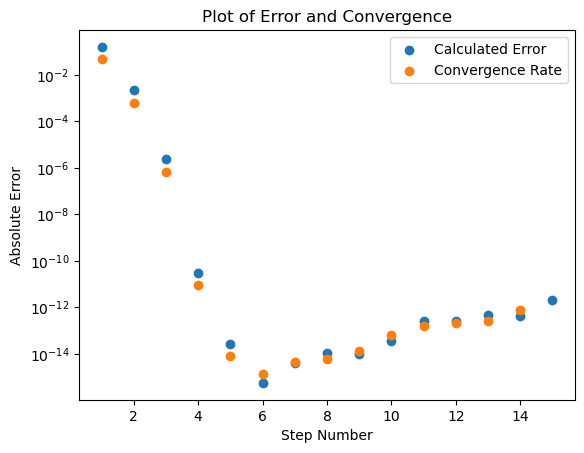

In [37]:
F = richardson_center(sf.jv, 0, 0.5, 15, (x,))
plt.scatter(np.arange(1, 16), np.abs((analytic - np.diag(F)) / analytic), label = "Calculated Error")
plt.scatter(np.arange(1, 15), np.abs(np.diff(np.diag(F))), label = "Convergence Rate")
plt.yscale('log')
plt.title("Plot of Error and Convergence")
plt.ylabel('Absolute Error')
plt.xlabel('Step Number')
plt.legend()

Notice that the error and convergence rate agree fairly well and are decreasing until about step 6.
What happens here?
Why does the error flatten out and then start to grow?


As shown before, the number of lost bits grows as the subtracted numbers get closer together, and therefore the error implied by those lost bits grows as well. If we were using perfect rational numbers with unlimited precision we would see the error continue to decrease, however with floats we see the error from the loss of significance overtake the other (shrinking) error from the algorithm.

### Derivative at Arbitrary Integer Order

The derivative can actually be calculated at any arbitrary integer order, $n$.
Mathematically this is given by
$$ \left. \frac{\mathrm{d}J_\nu(x)}{\mathrm{d}\nu} \right|_{\nu=n} = \frac\pi{2} Y_n(x) + \frac{n!}{2(x/2)^n} \sum_{k=0}^{n-1} \frac{(x/2)^k J_k(x)}{(n-k) k!}. $$
Here we will explore this more general relationship.

#### Small Order

Calculate the derivative for $n=6$ again at $x=3.5$ now using Richardson extrapolation with 8 steps.
Print the *fractional error* in the best estimate.
Recall from the prelab that we can calculate the true value without using loops by instead using the numpy `sum` function.
Also note that there are a few ways to calculate the factorial.
One is to relate it to the gamma function: $n! = \Gamma(n+1)$, and the gamma function is provided for us in `scipy.special`.

In [38]:
n = 6
x = 3.5
def analytic(n, x):
    ks = np.arange(0, n)
    return np.pi / 2 * sf.yn(n, x) + sf.gamma(n + 1) / (2 * (x / 2) ** n) * np.sum((x / 2) ** ks * sf.jn(ks, x) / (n - ks) / sf.gamma(ks + 1))

analytic_value = analytic(n, x)
ctr = richardson_center(sf.jv, 6, 0.5, 8, (x,))[-1,-1]
print(f"analytic: {analytic_value}, richardson deriv: {ctr}, frac_err = {np.abs((ctr - analytic_value) / analytic_value)}")

analytic: -0.031663431805608155, richardson deriv: -0.03166343180560439, frac_err = 1.1899592605607197e-13


#### Large Order

You may wonder why we are bothering with the numerical derivative since we have an analytic expression.
It is not *just* to keep you busy.
There are occasions when the analytic expression is not numerically useful, this is one such case.

Now calculate the derivative at $x=3.5$ again using 8 steps of Richardson extrapolation and the analytic expression but now for $\nu=40$.
Print the best estimate from Richardson extrapolation and also the value from the analytic expression.
(*Note:* It will be convenient for the discussion below to calculate and store the two terms in the analytic expression separately.)

In [39]:
n = 40
x = 3.5
analytic_value = analytic(n, x)
ctr = richardson_center(sf.jv, 6, 0.5, 8, (x,))[-1,-1]
print(f"analytic: {analytic_value}, richardson deriv: {ctr}, frac_err = {np.abs((ctr - analytic_value) / analytic_value)}")

analytic: -5.902958103587057e+20, richardson deriv: -0.03166343180560439, frac_err = 1.0


The answers should be entirely inconsistent.
What happened and which one do you believe?
To explore this print the two terms from the analytic expression.
Do you see a problem?

In [40]:
ks = np.arange(0, n)
a = np.pi / 2 * sf.yn(n, x)
b = sf.gamma(n + 1) / (2 * (x / 2) ** n) * np.sum((x / 2) ** ks * sf.jn(ks, x) / (n - ks) / sf.gamma(ks + 1))
print(f"""First term: {a}\nSecond term: {b}""")
print(f"Lost digits: {count_shared_mantissa_bits(a, b)}")
print("We have lost all but 2 bits of the mantissa!")

First term: -2.0949406458837998e+36
Second term: 2.0949406458837992e+36
Lost digits: 50
We have lost all but 2 bits of the mantissa!


Based on the previous part, which estimate do you believe is the correct one for the derivative?
Explain why you believe this estimate and what went wrong with the other one.

We believe that our Richardson extrapolation value is the correct one. In the analytic computation, both numbers blew up in a way that would cancel out. Due to finite precision, they won't be able to cancel like they're supposed to; we can see that we end up losing 50 of the 52 mantissa bits. We can estimate the absolute error from loss of precision by multiplying the exponent by the remaining precision to find
$$\begin{align}
\text{absolute error} \approx 10^{36}\cdot 2^{-50} \approx 8.89 \cdot 10^{20}
\end{align}$$
(Really, we should use the base 2 exponent, but this is good enough to get an idea of the possible error).

From above our function derived from the analytic expression gave us a number on the order of $10^{20}$, which aligns with our estimate of the error and shows that there is basically no significance in this analytic function result.

## Member Participation

See Lab00 for instructions on turning in labs.
We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who participated in this lab.
Again, see Lab00 for more details.
It is expected that you have read and understood those details.

sjl132, avv26, nxm642